In [1]:
import numpy as np
import pandas as pd
import os
from tqdm.auto import tqdm

In [2]:
import warnings
warnings.filterwarnings('ignore')
import torch
from torchvision import transforms, models, datasets
import numpy as np
import torch.optim as optim
import torch.nn as nn
import pandas as pd
import os
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
import cv2
import timm
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
from collections import OrderedDict

In [13]:
labels_csv = {'train': "/scratch/scratch6/akansh12/DeepEXrays/physionet.org/files/vindr-cxr/1.0.0/annotations/image_labels_train.csv",
             'test': "/scratch/scratch6/akansh12/DeepEXrays/physionet.org/files/vindr-cxr/1.0.0/annotations/image_labels_test.csv"
             }
data_dir = {'train': "/scratch/scratch6/akansh12/DeepEXrays/data/data_256/train/",
           'test': "/scratch/scratch6/akansh12/DeepEXrays/data/data_256/test/"}

In [59]:
global_labels = ['Pleural effusion', 'Lung tumor', 'Pneumonia', 'Tuberculosis', 'Other diseases', 'No finding']

In [5]:
#dataset
class Vin_big_dataset(Dataset):
    def __init__(self, image_loc, label_loc, transforms, data_type, selec_radio, radio_id = None):
        global_labels = ['Pleural effusion', 'Lung tumor', 'Pneumonia', 'Tuberculosis', 'Other diseases', 'No finding']
        
        if data_type == 'train':
            label_df = pd.read_csv(label_loc)
            if selec_radio == 'rand_one':
                label_df['labels'] = label_df['image_id']
                label_df.set_index("labels", inplace = True)
                filenames = np.unique(label_df.index.values).tolist()
                self.full_filenames = [os.path.join(image_loc, i +'.png') for i in filenames]
                self.labels = []
                for i in (filenames):
                    self.labels.append(label_df[global_labels].loc[i].values.tolist()[np.random.choice([0,1,2])])
                self.labels = torch.tensor(self.labels)
            if selec_radio == 'agree_two':
                label_df['labels'] = label_df['image_id']
                label_df.set_index("labels", inplace = True)
                filenames_temp = np.unique(label_df.index.values).tolist()
                self.labels = []
                filenames = []
                for i in filenames_temp:
                    a,b = np.unique(label_df.loc[i][global_labels].values, axis = 0, return_counts=True)
                    if b[0] >= 2:
                        filenames.append(i)
                        self.labels.append(a[0])
                self.labels = torch.tensor(self.labels)
                self.full_filenames = [os.path.join(image_loc, i +'.png') for i in filenames]
            if selec_radio == 'agree_three':
                label_df['labels'] = label_df['image_id']
                label_df.set_index("labels", inplace = True)
                filenames_temp = np.unique(label_df.index.values).tolist()
                self.labels = []
                filenames = []
                for i in filenames_temp:
                    a,b = np.unique(label_df.loc[i][global_labels].values, axis = 0, return_counts=True)
                    if b[0] == 3:
                        filenames.append(i)
                        self.labels.append(a[0])
                self.labels = torch.tensor(self.labels)
                self.full_filenames = [os.path.join(image_loc, i +'.png') for i in filenames]
            if selec_radio == 'radio_per_epoch':
                label_df['labels'] = label_df['image_id']
                label_df.set_index("labels", inplace = True)
                filenames = np.unique(label_df.index.values).tolist()
                self.labels = []
                for i in filenames:
                    self.labels.append(label_df.loc[i][global_labels].values[radio_id].tolist())
                self.labels = torch.tensor(self.labels)
                self.full_filenames = [os.path.join(image_loc, i +'.png') for i in filenames]
            if selec_radio == 'all': 
                label_df['labels'] = label_df['image_id'] +'_'+ label_df['rad_id']
                label_df.set_index("labels", inplace = True)
                filenames = label_df.index.values.tolist()
            
                self.full_filenames = [os.path.join(image_loc, i.split('_')[0]+'.png') for i in filenames]
                self.labels = []
                for i in tqdm(filenames):
                    self.labels.append(label_df[global_labels].loc[i].values.tolist())         
                self.labels = torch.tensor(self.labels)
                
        if data_type == 'test':                     
            filenames = os.listdir(image_loc)
            self.full_filenames = [os.path.join(image_loc, i) for i in filenames]
            label_df = pd.read_csv(label_loc)
            label_df.set_index("image_id", inplace = True)
            self.labels = [label_df[global_labels].loc[filename[:-4]].values for filename in filenames]
            
        self.transforms = transforms
#         self.data_type = data_type
    def __len__(self):
        return len(self.full_filenames)
    
    def __getitem__(self, idx):
        image = Image.open(self.full_filenames[idx])
        image = self.transforms(image)
        
        return image, self.labels[idx]
    
            

In [19]:
data_transforms = { 
    "train": transforms.Compose([
        transforms.RandomHorizontalFlip(p = 0.5), 
        transforms.RandomPerspective(distortion_scale=0.3),
        transforms.RandomRotation((-30,30)),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ]),
    
    "test": transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])        
    ])
    
}
test_dataset = Vin_big_dataset(image_loc = data_dir['test'],
                          label_loc = labels_csv['test'],
                          transforms = data_transforms['test'],
                          data_type = 'test', selec_radio = None)
testloader = DataLoader(test_dataset,batch_size = 1,shuffle = True)

In [7]:
model = models.densenet201(pretrained=False)
model.classifier = nn.Sequential(OrderedDict([
    ('fcl1', nn.Linear(1920,6)),
    ('out', nn.Sigmoid()),
]))

state_dict = torch.load("/scratch/scratch6/akansh12/DeepEXrays/model/0.927723_.pth", map_location = 'cpu')['state_dict']
for keyA, keyB in zip(state_dict, model.state_dict()):
    state_dict = OrderedDict((keyB if k == keyA else k, v) for k, v in state_dict.items())

model.load_state_dict(state_dict)

<All keys matched successfully>

In [56]:
test_label_df = pd.read_csv(labels_csv['test'])

In [73]:
test_label_df.head()

,image_id,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Clavicle fracture,Consolidation,Edema,Emphysema,Enlarged PA,...,Pneumothorax,Pulmonary fibrosis,Rib fracture,Other lesion,COPD,Lung tumor,Pneumonia,Tuberculosis,Other diseases,No finding
0,e0dc2e79105ad93532484e956ef8a71a,0,1,1,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,1,0
1,0aed23e64ebdea798486056b4f174424,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,aa15cfcfca7605465ca0513902738b95,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,665c4a6d2693dc0286d65ab479c9b169,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,42da2c134b53cb5594774d3d29faac59,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [60]:
test_label_df[global_labels]

,Pleural effusion,Lung tumor,Pneumonia,Tuberculosis,Other diseases,No finding
0,1,0,1,0,1,0
1,1,0,1,0,0,0
2,0,0,0,1,0,0
3,0,1,0,0,0,0
4,0,0,0,0,1,0
...,...,...,...,...,...,...
2995,0,0,0,0,0,1
2996,0,0,0,0,0,1
2997,0,0,0,0,0,1
2998,0,0,0,0,0,1


### Saliency Map

In [36]:
import saliency.core as saliency
import PIL.Image
from matplotlib import pylab as P

In [8]:
def ShowImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im)
    P.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
    P.title(title)

def ShowHeatMap(im, title, ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap='inferno')
    P.title(title)

def LoadImage(file_path):
    im = PIL.Image.open(file_path)
    im = im.resize((254, 254))
    im = np.asarray(im)
    return im

def PreprocessImages(images):
    # assumes input is 4-D, with range [0,255]
    #
    # torchvision have color channel as first dimension
    # with normalization relative to mean/std of ImageNet:
    #    https://pytorch.org/vision/stable/models.html
    images = np.array(images)
    images = images/255
    images = np.transpose(images, (0,3,1,2))
    images = torch.tensor(images, dtype=torch.float32)
    images = transformer.forward(images)
    return images.requires_grad_(True)

In [55]:
def call_model_function(images, call_model_args=None, expected_keys=None):
    images = PreprocessImages(images)
    target_class_idx =  call_model_args[class_idx_str]
    output = model(images)
    m = torch.nn.Softmax(dim=1)
    output = m(output)
    if saliency.base.INPUT_OUTPUT_GRADIENTS in expected_keys:
        outputs = output[:,target_class_idx]
        grads = torch.autograd.grad(outputs, images, grad_outputs=torch.ones_like(outputs))
        grads = torch.movedim(grads[0], 1, 3)
        gradients = grads.detach().numpy()
        return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
    else:
        one_hot = torch.zeros_like(output)
        one_hot[:,target_class_idx] = 1
        model.zero_grad()
        output.backward(gradient=one_hot, retain_graph=True)
        return conv_layer_outputs

In [38]:
transformer = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

Prediction class: [1 0 0 0 1 0]


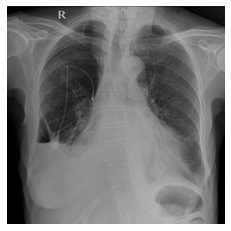

In [58]:
# Load the image
im_orig = LoadImage("/scratch/scratch6/akansh12/DeepEXrays/data/data_256/test/e0dc2e79105ad93532484e956ef8a71a.png")
im_tensor = PreprocessImages([im_orig])
# Show the image
ShowImage(im_orig)

predictions = model(im_tensor)
predictions = predictions.detach().numpy()
prediction_class = (predictions[0]>0.5).astype('int')
call_model_args = {class_idx_str: prediction_class}

print("Prediction class: " + str(prediction_class))  # Should be a doberman, class idx = 236
im = im_orig.astype(np.float32)


In [72]:
(predictions*100).astype('int')

array([[99,  0,  5,  0, 99,  0]])

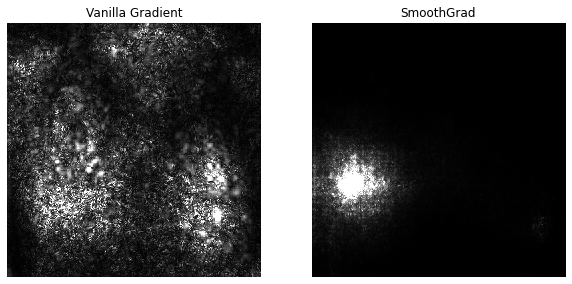

In [67]:
gradient_saliency = saliency.GradientSaliency()

# Compute the vanilla mask and the smoothed mask.
vanilla_mask_3d = gradient_saliency.GetMask(im, call_model_function, call_model_args)
smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(im, call_model_function, call_model_args)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_mask_3d)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Gradient', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='SmoothGrad', ax=P.subplot(ROWS, COLS, 2))

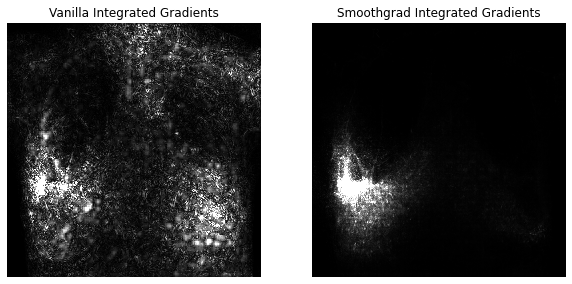

In [63]:
# Construct the saliency object. This alone doesn't do anthing.
integrated_gradients = saliency.IntegratedGradients()

# Baseline is a black image.
baseline = np.zeros(im.shape)

# Compute the vanilla mask and the smoothed mask.
vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
  im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)
# Smoothed mask for integrated gradients will take a while since we are doing nsamples * nsamples computations.
smoothgrad_integrated_gradients_mask_3d = integrated_gradients.GetSmoothedMask(
  im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)
smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_integrated_gradients_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Integrated Gradients', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='Smoothgrad Integrated Gradients', ax=P.subplot(ROWS, COLS, 2))

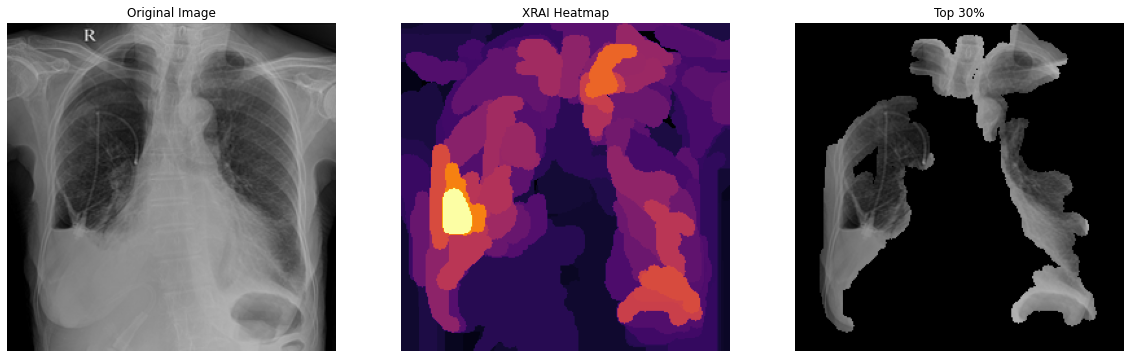

In [64]:
# Construct the saliency object. This alone doesn't do anthing.
xrai_object = saliency.XRAI()

# Compute XRAI attributions with default parameters
xrai_attributions = xrai_object.GetMask(im, call_model_function, call_model_args, batch_size=20)

# Set up matplot lib figures.
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 20
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Show original image
ShowImage(im_orig, title='Original Image', ax=P.subplot(ROWS, COLS, 1))

# Show XRAI heatmap attributions
ShowHeatMap(xrai_attributions, title='XRAI Heatmap', ax=P.subplot(ROWS, COLS, 2))

# Show most salient 30% of the image
mask = xrai_attributions > np.percentile(xrai_attributions, 70)
im_mask = np.array(im_orig)
im_mask[~mask] = 0
ShowImage(im_mask, title='Top 30%', ax=P.subplot(ROWS, COLS, 3))

In [ ]:
model.eval()

In [29]:
for x, y in testloader:
    print(x.shape)
    print(y)
    break

torch.Size([1, 3, 256, 256])
tensor([[0, 0, 0, 0, 1, 0]])


In [30]:
model.eval()
out = model(x)